# Analysis pipeline : image to axon/myeling statistic
This pipeline generate the prediction of the mask for a RGB image (using a convertion) and apply the myelin segmentation then create the statistics with corresponding plot.<br>
This analysis doesn't requires ground truth data
1. import raw image and the model
2. Apply the model to image 
3. myelin instance segmentation 
4. Create a dataframe
5. Statistic and plots

In [24]:
import os
from PIL import Image
from PIL import ImageOps
import numpy as np
import skimage.io as io
import math
import matplotlib.pyplot as plt
from keras.models import load_model

os.chdir('/home/thibault/Documents/Thibault_Python_dev/Unet_TT')
import Performance_measurement as Perf_m
import Apply_model
from Utility import Image_2_np, Image_import
import Myelin_segmentation_utility as ms_uti


os.chdir('/home/thibault/Documents/Thibault_Python_dev/thibault_toolbox')
from utility_plot import *

### 1- Import raw data and model

In [61]:
# import model and image
popping_window = False # True if you want to assign manually the model and the image
                        # or False if you want to choose from popping window

if not popping_window: # if you want to assign manual model and image
    model_path = '/home/thibault/Documents/Data/ADS/Model_Unet_tt/2019-02-04_1604.h5'
    image_path = '/home/thibault/Documents/Data/ADS/Training_256_v5/Gray/Raw_data/Test/sample3/image_RGB.png'
    img, model, folder_path = Apply_model.prepare_(model_path = model_path, test_image_path = image_path)
    
if popping_window: # if you want to choose model and image from pop window
    img, model, folder_path = Apply_model.prepare_()
    
print('folder_path: ',folder_path)

folder_path:  /home/thibault/Documents/Data/ADS/Training_256_v5/Gray/Raw_data/Test/sample3


### Change the image only using a pop-up window

In [26]:
img, folder_path = Image_import()

### 2- Apply model

In [59]:
# Apply the model
pred_image = Apply_model.Unet_by_patches(img, model, patch_size = 256, overlap=64)

mask = np.argmax(pred_image, axis=-1)
mask=127*mask.astype(np.uint8)

100%|██████████| 108/108 [00:03<00:00, 27.98it/s]


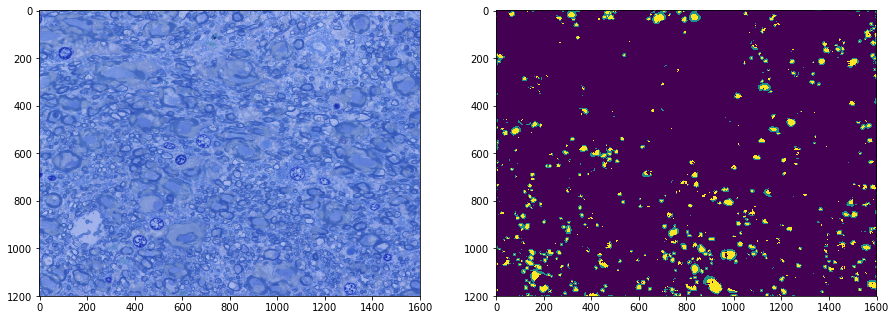

In [60]:
# Sanity check
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,10))
ax[0].imshow(np.array(img))
ax[1].imshow(mask)

In [38]:
# save the image either as numpy array or as image or skip this part
save_as = 'image' # choose : 'image' or 'np'
if save_as == 'image':
    io.imsave(folder_path+ '/unet_image.png', mask)
else:
    np.save(folder_path + '/unet_np_array', mask)


## 3- Myelin instance segmentation


### Myelin Segmentation of the predicted mask

In [39]:
# Segment the fibers
print(folder_path)
fiber_pred_seg = ms_uti.quick_myelin_seg(mask)
_, _, label_fiber_pred, label_axon_pred  = ms_uti.clean_up (fiber_pred_seg, mask)
del fiber_pred_seg, mask

/home/thibault/Documents/Data/ADS/fig_CST/fig1


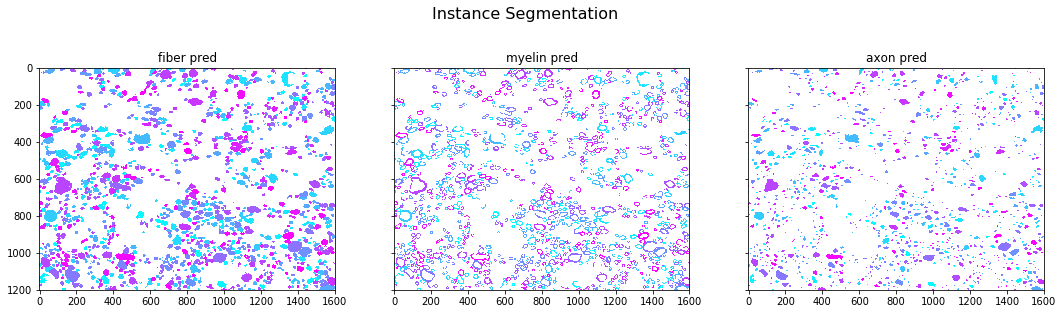

In [40]:
# Sanity check
# Display the segmentation of the fiber
label_myelin_pred = label_fiber_pred-label_axon_pred
mycolor=ms_uti.random_cmap(label_fiber_pred.max(),'cool')
fig, ax =  plt.subplots(figsize = (18,5),nrows=1, ncols=3, sharex=True, sharey=True)
fig.suptitle('Instance Segmentation', fontsize = 16)
ax=ax.flatten()
ax[0].imshow(label_fiber_pred, cmap =mycolor)
ax[0].set_title('fiber pred')
ax[1].imshow(label_myelin_pred, cmap =mycolor)
ax[1].set_title('myelin pred')
ax[2].imshow(label_axon_pred, cmap =mycolor)
ax[2].set_title('axon pred')
plt.show()

## 4- Create dataframe

In [42]:
df = Perf_m.Fiber_morpho_v2(label_fiber_pred, label_axon_pred)

## 5- Statistic and plot

### Step 1 
Choose the feature you want to plot in the next cell (__# Choose the feature you want to plot__)
> Options are Axon diameter, Gratio, Myelin Thickness<br>
> Run each of interest. Becareful some cell need the output from previous cell


In [53]:
# Choose the feature you want to plot
measured_option = {'Axon diameter':('diam_a','${\mu}m$' ), 'Gratio':('gratio',''),
                   'Myelin Thickness':('myelin_thick','${\mu}m$')}
feature = 'Myelin Thickness' # from 'Axon diameter', 'Gratio' or 'Myelin Thickness'


#
pred = measured_option[feature][0]
unit = measured_option[feature][1]
measured = feature



### plot 1
- Plot the histogram distribution of the predicted feature.
- show the partition between True Positive(blue) and False Positive(green).
- Indicate the position of the peak value

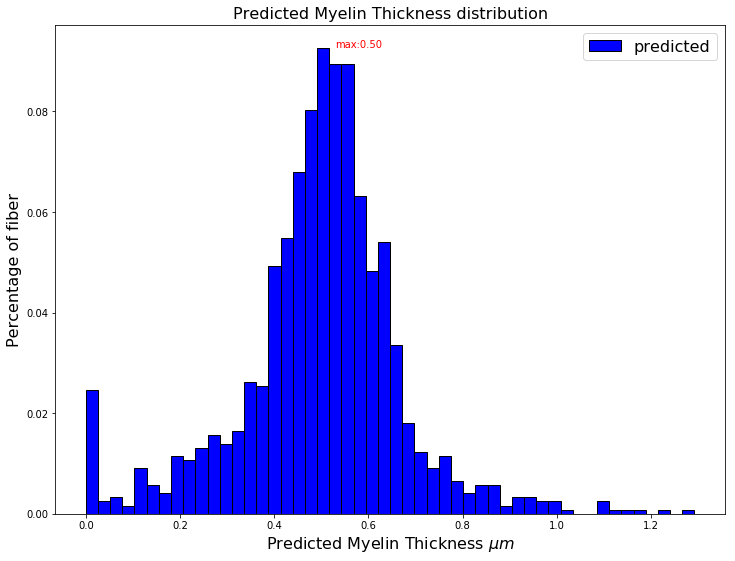

In [54]:
# plot 1
title_1 = 'Predicted {0} distribution'. format(measured)
x_label_1 = 'Predicted {0} {1}'. format(measured, unit)
y_label_1 = 'Percentage of fiber'

pred_xx = df[pred]
bins,fig = bar_plot_dist_1_categ(pred_xx, legend='predicted', bins=50, display_max=True)
plt.xlabel(x_label_1, fontsize=16); plt.ylabel(y_label_1, fontsize=16)
plt.title(title_1, fontsize=16)
plt.show()

In [51]:
# Save the fig
from tkinter import filedialog
from tkinter import Tk

In [55]:
specific_tag= 'CSTfig1'# for instance CST_fig1
root = Tk()
root.withdraw()# we don't want a full GUI, so keep the root window from appearing
dir_name =  filedialog.askdirectory(initialdir = '/home/thibault/Documents/Data/ADS/',\
                                                      title = 'choose directory location to save the plot') 
save_plot_name = os.path.join(dir_name, 'plot1_{0}_{1}'.format(specific_tag,feature))
fig.savefig(save_plot_name)

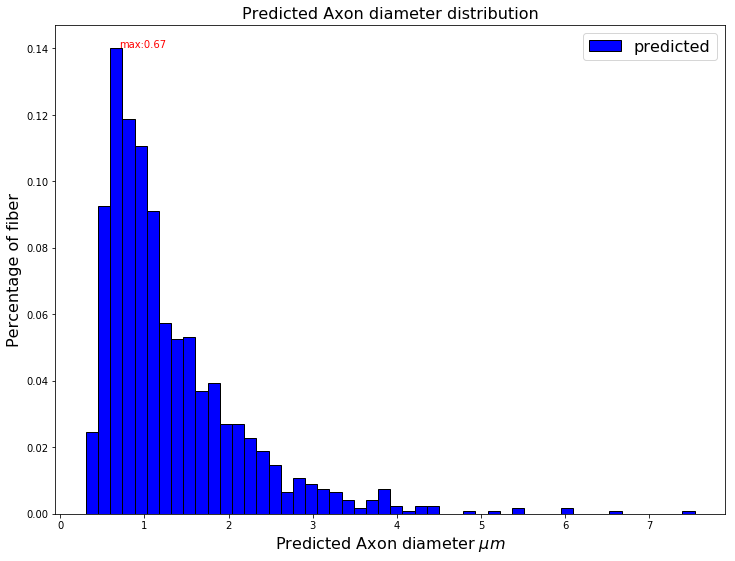

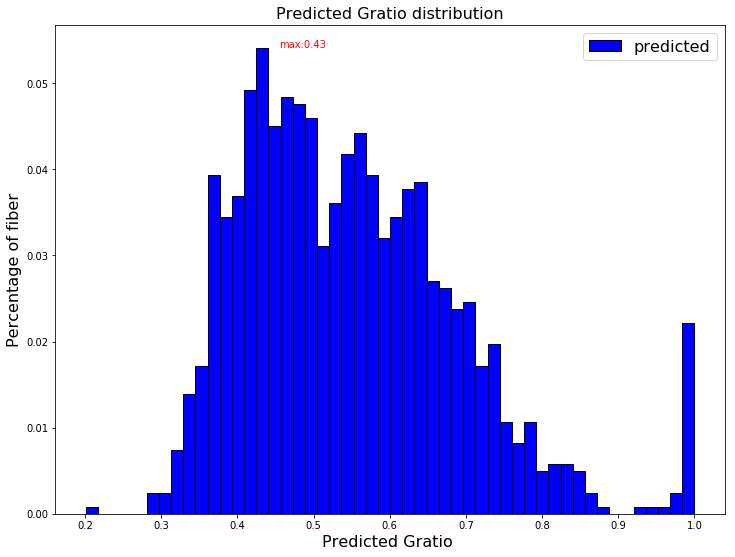

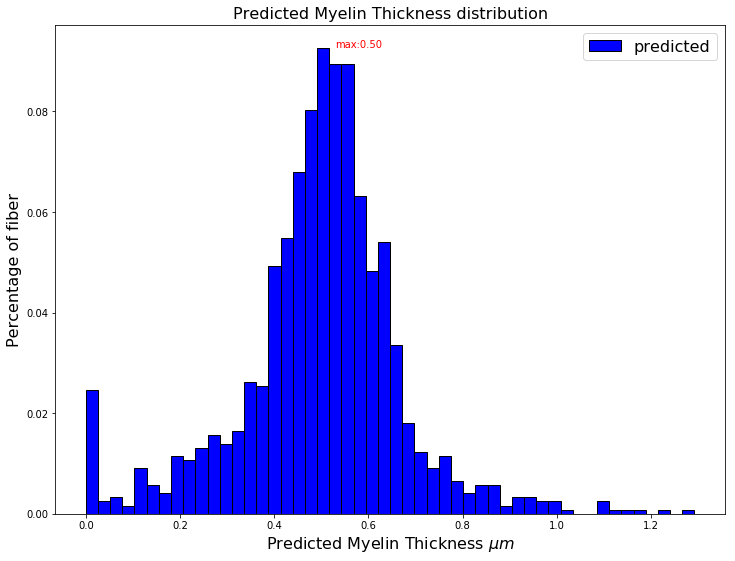

In [57]:
# loop over the different feature  to plot all at once
specific_tag= 'CSTfig1'# for instance CST_fig1
root = Tk()
root.withdraw()# we don't want a full GUI, so keep the root window from appearing
dir_name =  filedialog.askdirectory(initialdir = '/home/thibault/Documents/Data/ADS/',\
                                                      title = 'choose directory location to save the plot')
for feature in measured_option.keys():
    
    pred = measured_option[feature][0]
    unit = measured_option[feature][1]
    measured = feature
    
    # plot 1
    title_1 = 'Predicted {0} distribution'. format(measured)
    x_label_1 = 'Predicted {0} {1}'. format(measured, unit)
    y_label_1 = 'Percentage of fiber'

    pred_xx = df[pred]
    bins,fig = bar_plot_dist_1_categ(pred_xx, legend='predicted', bins=50, display_max=True)
    plt.xlabel(x_label_1, fontsize=16); plt.ylabel(y_label_1, fontsize=16)
    plt.title(title_1, fontsize=16)
    plt.show()
    save_plot_name = os.path.join(dir_name, 'plot1_{0}_{1}'.format(specific_tag,feature))
    fig.savefig(save_plot_name)
